### Gerekli Kütüphaneler

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import collections
import seaborn as sns
from networkx.algorithms import community
from pyvis.network import Network
import time
import random
import pandas as pd
from matplotlib import cm
import requests
import gzip
import os

### Veri Setinin İndirilmesi ve NetworkX Kütüphanesi ile Import Edilmesi

In [51]:
# URL for the web-Google.txt.gz dataset
url = "http://snap.stanford.edu/data/web-Google.txt.gz"

# File paths
gz_file_path = "web-Google.txt.gz"
txt_file_path = "web-Google.txt"

# Download the dataset if it doesn't exist locally
if not os.path.exists(gz_file_path):
    print(f"Downloading {url}...")
    response = requests.get(url, stream=True)
    with open(gz_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download completed!")
else:
    print(f"File {gz_file_path} already exists.")

# Extract the .gz file if the .txt file doesn't exist locally
if not os.path.exists(txt_file_path):
    print(f"Extracting {gz_file_path}...")
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(txt_file_path, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Extraction completed!")
else:
    print(f"File {txt_file_path} already exists.")

print("Creating the directed graph...")
G = nx.DiGraph()

with open(txt_file_path, 'r') as f:
    for line in f:
        line = line.strip()
        # Skip comment lines
        if line.startswith('#'):
            continue
        # Parse the edge information
        nodes = line.split()
        if len(nodes) >= 2:
            from_node = int(nodes[0])
            to_node = int(nodes[1])
            G.add_edge(from_node, to_node)

print(f"Graph created successfully!")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

File web-Google.txt.gz already exists.
File web-Google.txt already exists.
Creating the directed graph...
Graph created successfully!
Number of nodes: 875713
Number of edges: 5105039


### Graf Örnekleme (Graph Sampling)


Büyük grafı örnekleme...
Orijinal graf: 875713 düğüm, 5105039 kenar
PageRank hesaplanıyor...
Graf tam bağlı değil, en büyük bileşeni seçiyoruz...

Örneklenmiş graf özellikleri:
Düğüm sayısı: 9985
Kenar sayısı: 73074
Ortalama kümeleme katsayısı: 0.5140202235311561
Ortalama en kısa yol uzunluğu hesaplanıyor (örnekleme ile)...
Ortalama en kısa yol uzunluğu (örneklenmiş): 7.8730
Ortalama gelen derece: 7.3184
Ortalama giden derece: 7.3184
Maksimum gelen derece: 5158
Maksimum giden derece: 171

Orijinal ve örneklenmiş graf karşılaştırması:
Orijinal: 875713 düğüm, 5105039 kenar
Örneklenmiş: 9985 düğüm, 73074 kenar
Azaltma oranı (düğümler): 0.0114
Azaltma oranı (kenarlar): 0.0143


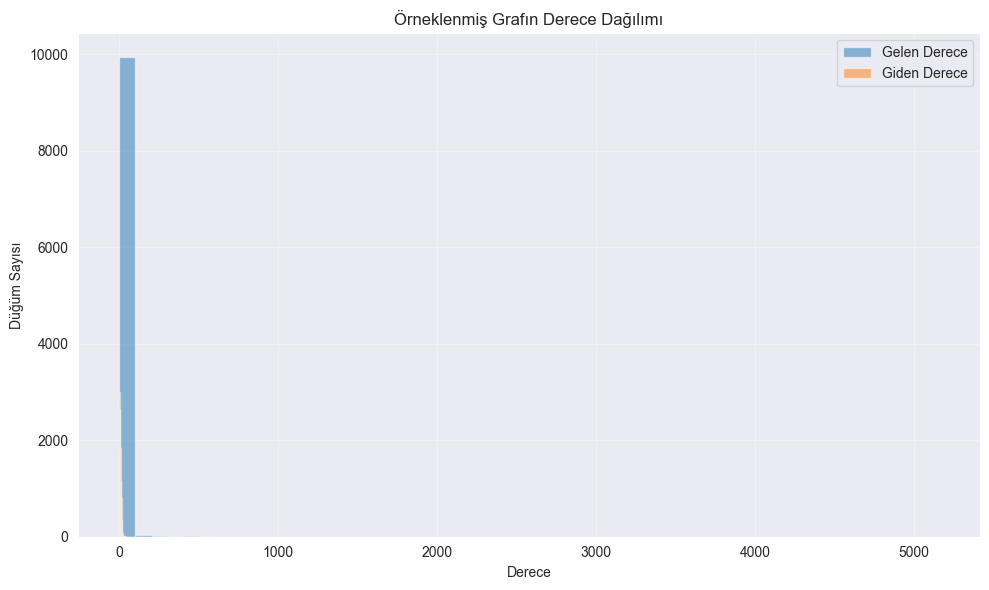

In [40]:
# Graf örnekleme teknikleri uygulayarak daha küçük bir graf oluşturalım
print("Büyük grafı örnekleme...")
print(f"Orijinal graf: {G.number_of_nodes()} düğüm, {G.number_of_edges()} kenar")

# Stratejimiz:
# 1. Yüksek PageRank skoruna sahip önemli düğümlerden başlayarak
# 2. Bunların etrafındaki toplulukları (komşulukları) alarak
# 3. 5000-10000 düğümlük bir alt graf oluşturacağız

# PageRank hesaplayarak önemli düğümleri bulalım
print("PageRank hesaplanıyor...")
pagerank = nx.pagerank(G, alpha=0.85, max_iter=100)

# En yüksek PageRank değerine sahip düğümleri sıralayalım
top_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
top_nodes = [node for node, score in top_nodes[:500]]  # En önemli 500 düğüm

# Bu önemli düğümler ve çevrelerini temel alan örnekleme yapalım
# İlk olarak, belirli sayıda önemli düğümü seçelim (hedef düğüm sayısına göre)
seed_nodes = set(top_nodes[:100])  # En önemli 100 düğümü seçiyoruz
target_nodes = 10000  # Hedeflenen düğüm sayısı (5000-10000 arası)

# Bu çekirdek düğümleri genişletelim
current_nodes = seed_nodes.copy()
frontier = seed_nodes.copy()
visited = set()

# BFS benzeri bir yaklaşımla genişletelim, ancak önceliği yüksek PageRank'e verelim
while len(current_nodes) < target_nodes and frontier:
    # Sınırdaki düğümleri PageRank'e göre sırala
    frontier_ranks = [(n, pagerank.get(n, 0)) for n in frontier]
    frontier_ranks.sort(key=lambda x: x[1], reverse=True)

    # En yüksek PageRank'li düğümü seç
    current = frontier_ranks[0][0]
    frontier.remove(current)
    visited.add(current)

    # Komşularını ekle
    neighbors = set(G.successors(current)) | set(G.predecessors(current))
    neighbors = neighbors - visited

    # Eğer hala hedef düğüm sayısına ulaşmadıysak, komşuları ekle
    if len(current_nodes) + len(neighbors) <= target_nodes:
        current_nodes.update(neighbors)
        frontier.update(neighbors)
    else:
        # Hedef sayıya ulaşacak kadar komşu ekle
        remaining = target_nodes - len(current_nodes)
        # Komşuları PageRank'e göre sırala ve en önemlilerini ekle
        neighbors_ranks = [(n, pagerank.get(n, 0)) for n in neighbors]
        neighbors_ranks.sort(key=lambda x: x[1], reverse=True)
        top_remaining = [n for n, _ in neighbors_ranks[:remaining]]
        current_nodes.update(top_remaining)
        break

# Alt graf oluştur
G_sample = G.subgraph(current_nodes).copy()

# Bağlı bileşenler arasında en büyüğünü seç
if not nx.is_strongly_connected(G_sample):
    print("Graf tam bağlı değil, en büyük bileşeni seçiyoruz...")
    largest_cc = max(nx.weakly_connected_components(G_sample), key=len)
    G_sample = G_sample.subgraph(largest_cc).copy()

# Graf metriklerini hesapla ve göster
print("\nÖrneklenmiş graf özellikleri:")
print(f"Düğüm sayısı: {G_sample.number_of_nodes()}")
print(f"Kenar sayısı: {G_sample.number_of_edges()}")
print(f"Ortalama kümeleme katsayısı: {nx.average_clustering(G_sample)}")
print(f"Ortalama en kısa yol uzunluğu hesaplanıyor (örnekleme ile)...")

# En kısa yol uzunluğunu tahmin etmek için örnekleme (çok büyük graflarda tam hesaplama yavaş olabilir)
sample_size = min(100, G_sample.number_of_nodes())
sampled_nodes = random.sample(list(G_sample.nodes()), sample_size)
path_lengths = []

for u in sampled_nodes:
    for v in sampled_nodes:
        if u != v:
            try:
                path_lengths.append(nx.shortest_path_length(G_sample, u, v))
            except nx.NetworkXNoPath:
                # Yol yoksa eklemiyoruz
                pass

if path_lengths:
    print(f"Ortalama en kısa yol uzunluğu (örneklenmiş): {np.mean(path_lengths):.4f}")

# Derece dağılımını kontrol edelim
in_degrees = [d for n, d in G_sample.in_degree()]
out_degrees = [d for n, d in G_sample.out_degree()]

print(f"Ortalama gelen derece: {np.mean(in_degrees):.4f}")
print(f"Ortalama giden derece: {np.mean(out_degrees):.4f}")
print(f"Maksimum gelen derece: {np.max(in_degrees)}")
print(f"Maksimum giden derece: {np.max(out_degrees)}")

# Orijinal grafla basit karşılaştırma
print("\nOrijinal ve örneklenmiş graf karşılaştırması:")
print(f"Orijinal: {G.number_of_nodes()} düğüm, {G.number_of_edges()} kenar")
print(f"Örneklenmiş: {G_sample.number_of_nodes()} düğüm, {G_sample.number_of_edges()} kenar")
print(f"Azaltma oranı (düğümler): {G_sample.number_of_nodes() / G.number_of_nodes():.4f}")
print(f"Azaltma oranı (kenarlar): {G_sample.number_of_edges() / G.number_of_edges():.4f}")

# Örneklenmiş grafın derece dağılımını görselleştirelim
plt.figure(figsize=(10, 6))
plt.hist(in_degrees, bins=50, alpha=0.5, label='Gelen Derece')
plt.hist(out_degrees, bins=50, alpha=0.5, label='Giden Derece')
plt.xlabel('Derece')
plt.ylabel('Düğüm Sayısı')
plt.title('Örneklenmiş Grafın Derece Dağılımı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Test İçin Örneklenmiş Grafın Kullanılması (Tercihi)

In [41]:
G = G_sample

### Temel İstatistikler

#### Düğüm ve Kenar Sayısı

In [42]:
print(f"Düğüm Sayısı: {G.number_of_nodes()}")
print(f"Kenar Sayısı: {G.number_of_edges()}")

Düğüm Sayısı: 9985
Kenar Sayısı: 73074


#### İç ve dış derece

In [43]:
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
degree = dict(G.degree)

print(f"Ortalama Derece: {np.mean(list(degree.values())):.2f}")
print(f"Ortalama İç Derece: {np.mean(list(in_degrees.values())):.2f}")
print(f"Ortalama Dış Derece: {np.mean(list(out_degrees.values())):.2f}")

Ortalama Derece: 14.64
Ortalama İç Derece: 7.32
Ortalama Dış Derece: 7.32


#### Ağ Yoğunluğu

In [44]:
print(f"Ağ Yoğunluğu: {nx.density(G):.8f}")

Ağ Yoğunluğu: 0.00073301


#### Bağlantı güçleri

In [45]:
strong_components = list(nx.strongly_connected_components(G))
weak_components = list(nx.weakly_connected_components(G))

print(f"Strongly Connected Components sayısı: {len(strong_components)}")
print(f"Weakly Connected Components sayısı: {len(weak_components)}")

largest_strong = max(strong_components, key=len)
largest_weak = max(weak_components, key=len)

print(f"En büyük Strongly Connected Component boyutu: {len(largest_strong)}")
print(f"En büyük Weakly Connected Component boyutu: {len(largest_weak)}")

Strongly Connected Components sayısı: 4216
Weakly Connected Components sayısı: 1
En büyük Strongly Connected Component boyutu: 5108
En büyük Weakly Connected Component boyutu: 9985


#### Derece Dağılım Analizi

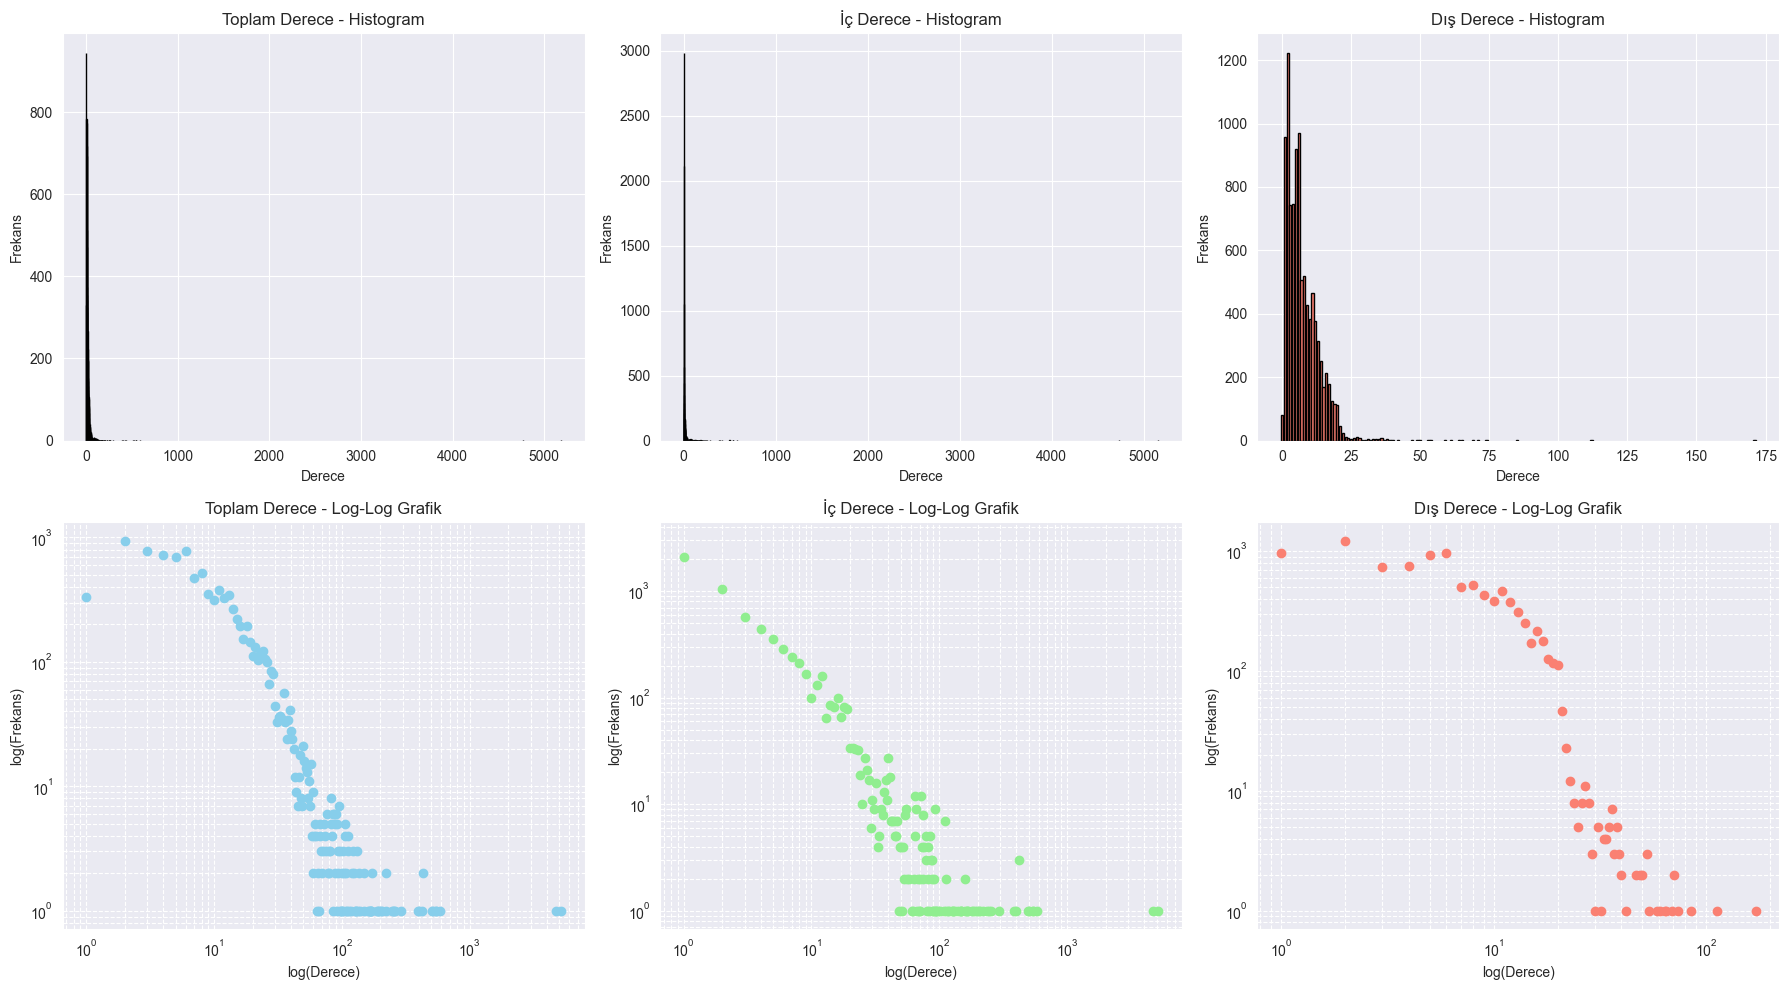

In [46]:
toplam_derece_listesi = [d for n, d in G.degree()]
ic_derece_listesi = [d for n, d in G.in_degree()]
dis_derece_listesi = [d for n, d in G.out_degree()]

dereceler = [
    ("Toplam Derece", toplam_derece_listesi, 'skyblue'),
    ("İç Derece", ic_derece_listesi, 'lightgreen'),
    ("Dış Derece", dis_derece_listesi, 'salmon')
]

fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # 2 satır 3 sütun

for i, (baslik, derece_listesi, renk) in enumerate(dereceler):
    derece_sayimi = collections.Counter(derece_listesi)
    derece, frekans = zip(*sorted(derece_sayimi.items()))

    axs[0, i].bar(derece, frekans, width=0.8, color=renk, edgecolor='black')
    axs[0, i].set_title(f"{baslik} - Histogram")
    axs[0, i].set_xlabel("Derece")
    axs[0, i].set_ylabel("Frekans")
    axs[0, i].grid(True)

    axs[1, i].loglog(derece, frekans, marker='o', linestyle='None', color=renk)
    axs[1, i].set_title(f"{baslik} - Log-Log Grafik")
    axs[1, i].set_xlabel("log(Derece)")
    axs[1, i].set_ylabel("log(Frekans)")
    axs[1, i].grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

### Topluluk Analizi (Community Detection)


Topluluk analizi yapılıyor...
Topluluk analizi tamamlandı. Süre: 1.05 saniye
Tespit edilen topluluk sayısı: 48
En büyük topluluk boyutu: 2543
En küçük topluluk boyutu: 13
Ortalama topluluk boyutu: 208.02
Medyan topluluk boyutu: 91.50
Topluluk içi kenar sayısı: 64056
Topluluklar arası kenar sayısı: 9018
Modülerlik oranı (iç kenarlar/toplam): 0.8766


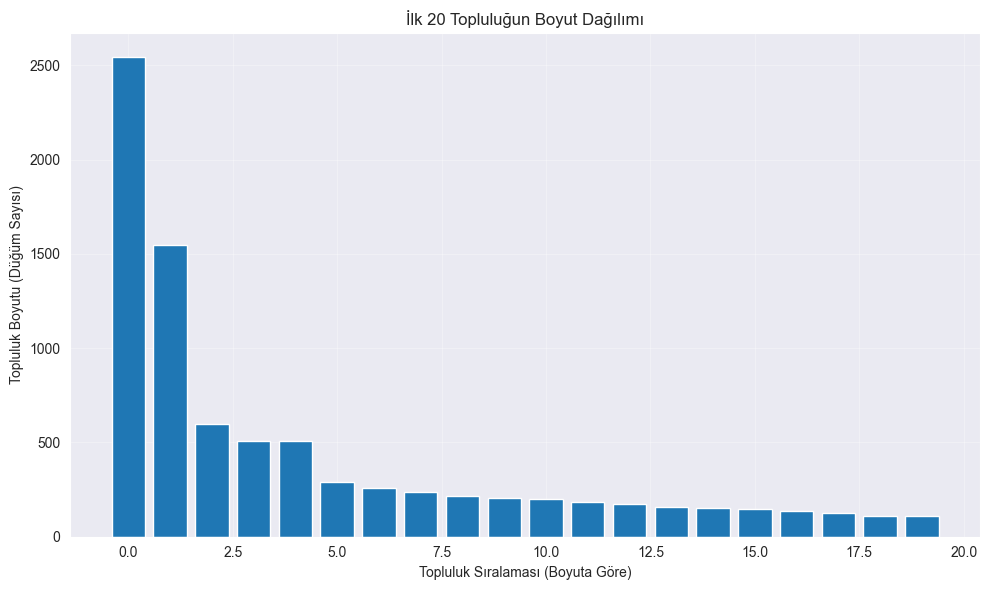

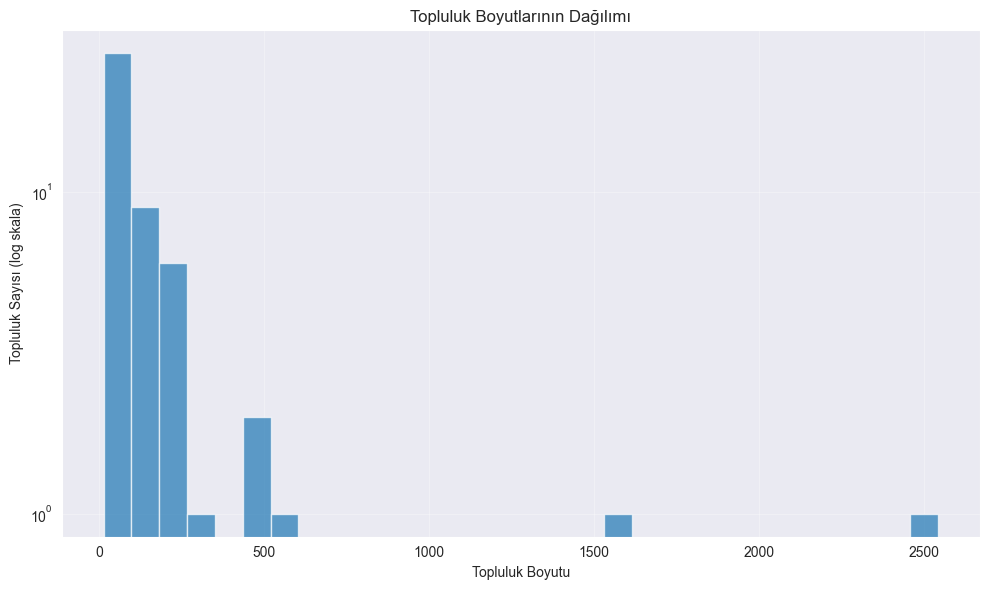

Graf çok büyük olduğu için görselleştirme atlandı.

En büyük 3 topluluğun özellikleri:
Topluluk 1: 2543 düğüm, 9801 kenar
  Bağlantı yoğunluğu: 0.001516
  En merkezi düğümler: [163075, 394956, 14672]
Topluluk 2: 1549 düğüm, 6514 kenar
  Bağlantı yoğunluğu: 0.002717
  En merkezi düğümler: [597621, 783319, 878167]
Topluluk 3: 596 düğüm, 4656 kenar
  Bağlantı yoğunluğu: 0.013130
  En merkezi düğümler: [698251, 107219, 122407]


In [47]:
# Örneklenmiş graf üzerinde topluluk analizi
print("Topluluk analizi yapılıyor...")
start_time = time.time()

# Louvain algoritması ile topluluk tespiti
communities = community.louvain_communities(G_sample.to_undirected(), resolution=1.0)
print(f"Topluluk analizi tamamlandı. Süre: {time.time() - start_time:.2f} saniye")

# Toplulukları düğüm özellikleri olarak kaydet
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i

# Topluluk boyutları ve dağılımları
community_sizes = [len(c) for c in communities]
print(f"Tespit edilen topluluk sayısı: {len(communities)}")
print(f"En büyük topluluk boyutu: {max(community_sizes)}")
print(f"En küçük topluluk boyutu: {min(community_sizes)}")
print(f"Ortalama topluluk boyutu: {np.mean(community_sizes):.2f}")
print(f"Medyan topluluk boyutu: {np.median(community_sizes):.2f}")

# Topluluklar arası bağlantı yoğunlukları
internal_edges = 0
external_edges = 0

for u, v in G_sample.edges():
    if u in community_map and v in community_map:
        if community_map[u] == community_map[v]:
            internal_edges += 1
        else:
            external_edges += 1

print(f"Topluluk içi kenar sayısı: {internal_edges}")
print(f"Topluluklar arası kenar sayısı: {external_edges}")
print(f"Modülerlik oranı (iç kenarlar/toplam): {internal_edges / (internal_edges + external_edges):.4f}")

# İlk 20 topluluğun boyut dağılımını görselleştirelim
plt.figure(figsize=(10, 6))
plt.bar(range(min(20, len(community_sizes))), sorted(community_sizes, reverse=True)[:20])
plt.grid(True, alpha=0.3)
plt.xlabel('Topluluk Sıralaması (Boyuta Göre)')
plt.ylabel('Topluluk Boyutu (Düğüm Sayısı)')
plt.title('İlk 20 Topluluğun Boyut Dağılımı')
plt.tight_layout()
plt.show()

# Topluluk boyutlarının genel dağılımını log skalada görelim
plt.figure(figsize=(10, 6))
plt.hist(community_sizes, bins=30, log=True, alpha=0.7)
plt.grid(True, alpha=0.3)
plt.xlabel('Topluluk Boyutu')
plt.ylabel('Topluluk Sayısı (log skala)')
plt.title('Topluluk Boyutlarının Dağılımı')
plt.tight_layout()
plt.show()

# Topluluklara göre renklendirilmiş graf görselleştirmesi (küçük örnekleme için)
if G_sample.number_of_nodes() <= 1000:
    # Çok büyük grafikler için bu adımı atlıyoruz
    sample_viz = G_sample.copy()
    # Düğüm özelliklerini ekleyelim
    nx.set_node_attributes(sample_viz, community_map, 'community')

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(sample_viz, seed=42)

    # Topluluklara göre renklendirme
    cmap = cm.get_cmap('tab20', len(communities))

    nx.draw_networkx_nodes(sample_viz, pos,
                           node_color=[community_map.get(n, 0) for n in sample_viz.nodes()],
                           cmap=cmap,
                           node_size=50,
                           alpha=0.8)

    nx.draw_networkx_edges(sample_viz, pos, alpha=0.1)
    plt.title(f'Topluluk Yapısı (İlk {sample_viz.number_of_nodes()} düğüm)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Graf çok büyük olduğu için görselleştirme atlandı.")

    # Alternatif olarak, en büyük 3 topluluğun alt graflarını inceleyebiliriz
    print("\nEn büyük 3 topluluğun özellikleri:")
    top_communities = sorted(communities, key=len, reverse=True)[:3]

    for i, comm in enumerate(top_communities):
        subgraph = G_sample.subgraph(comm).copy()
        print(f"Topluluk {i + 1}: {len(comm)} düğüm, {subgraph.number_of_edges()} kenar")

        # Topluluk içi bağlantı yoğunluğu
        possible_edges = len(comm) * (len(comm) - 1)
        density = subgraph.number_of_edges() / possible_edges if possible_edges > 0 else 0
        print(f"  Bağlantı yoğunluğu: {density:.6f}")

        # Topluluğun merkeziliği (en yüksek merkeziliğe sahip 3 düğüm)
        centrality = nx.degree_centrality(subgraph)
        top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f"  En merkezi düğümler: {[n for n, _ in top_central]}")


### PyVis ile İnteraktif Topluluk Görselleştirmesi

In [48]:
# Daha dengeli dağılımlı topluluk görselleştirmesi
print("PyVis ile geliştirilmiş topluluk görselleştirmesi hazırlanıyor...")

# Görselleştirme için ideal düğüm sayısı
max_nodes_for_viz = 7400  # Daha az düğüm daha iyi performans ve görsellik sağlar

# Düğümlerin daha iyi yerleşimi için önişleme
if G_sample.number_of_nodes() > max_nodes_for_viz:
    # Topluluk temelli örnekleme
    top_communities = sorted(communities, key=len, reverse=True)
    selected_nodes = set()

    # Her topluluktan dengeli şekilde düğüm seçme
    remaining_slots = max_nodes_for_viz

    # İlk olarak her topluluktan minimum bir miktar düğüm alalım (en az 5 veya topluluğun tamamı)
    min_per_community = 5
    for comm in top_communities:
        if len(comm) <= min_per_community:
            selected_nodes.update(comm)
            remaining_slots -= len(comm)
        else:
            # Her topluluktan minimum sayıda düğüm alalım
            page_ranked = sorted([(n, pagerank.get(n, 0)) for n in comm], key=lambda x: x[1], reverse=True)
            selected_nodes.update([n for n, _ in page_ranked[:min_per_community]])
            remaining_slots -= min_per_community

    # Sonra kalan slotları topluluk büyüklüğüne orantılı olarak dolduralım
    if remaining_slots > 0:
        # Şimdiye kadar seçilmeyen topluluk düğümlerini alalım
        remaining_comm_nodes = {}
        for i, comm in enumerate(top_communities):
            remaining_comm_nodes[i] = [n for n in comm if n not in selected_nodes]

        # Topluluk boyutlarına göre ek düğüm sayılarını hesaplayalım
        total_remaining_nodes = sum(len(nodes) for nodes in remaining_comm_nodes.values())

        # Düğümleri seçelim
        for comm_id, nodes in remaining_comm_nodes.items():
            if total_remaining_nodes == 0:
                break

            # Bu topluluk için kalan slotları hesapla
            alloc_slots = min(int(remaining_slots * (len(nodes) / total_remaining_nodes)), len(nodes))

            if alloc_slots > 0:
                # PageRank'e göre önemli düğümleri seç
                ranked_nodes = sorted([(n, pagerank.get(n, 0)) for n in nodes], key=lambda x: x[1], reverse=True)
                selected_nodes.update([n for n, _ in ranked_nodes[:alloc_slots]])
                remaining_slots -= alloc_slots

    # Seçilen düğümlerden alt graf oluştur
    viz_graph = G_sample.subgraph(selected_nodes).copy()

    # En büyük bağlı bileşeni alalım
    largest_cc = max(nx.weakly_connected_components(viz_graph), key=len)
    viz_graph = viz_graph.subgraph(largest_cc).copy()
else:
    viz_graph = G_sample.copy()

print(f"Görselleştirme için seçilen düğüm sayısı: {viz_graph.number_of_nodes()}")
print(f"Görselleştirme için seçilen kenar sayısı: {viz_graph.number_of_edges()}")

# Networkx ile ön yerleşim hesaplayalım - düğümleri daha iyi dağıtmak için
print("Düğüm yerleşimi hesaplanıyor...")
pos = nx.spring_layout(viz_graph.to_undirected(), seed=42, k=0.5, iterations=50)

# Renk paleti (farklı topluluklar için)
color_palette = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
    "#008080", "#e6beff", "#9a6324", "#fffac8", "#800000",
    "#aaffc3", "#808000", "#ffd8b1", "#000075", "#808080"
]

# PyVis ağı oluştur
net = Network(notebook=True, cdn_resources='in_line', directed=True, height="750px", width="100%", bgcolor="#ffffff")

# Düğüm topluluklarını belirle
node_communities = {}
for node in viz_graph.nodes():
    node_communities[node] = community_map.get(node, 0)

# Düğümleri ekle - önceden hesaplanan konumlarla
for node in viz_graph.nodes():
    # Topluluk rengini belirle
    comm_id = node_communities[node]
    color = color_palette[comm_id % len(color_palette)]

    # Düğüm boyutu - PageRank'e göre
    size = 5 + min(25, pagerank.get(node, 0) * 15000)

    # Bilgi metni
    title = f"Node: {node}<br>Community: {comm_id}<br>In-degree: {viz_graph.in_degree(node)}<br>Out-degree: {viz_graph.out_degree(node)}"

    # Önceden hesaplanan konumları (nx ile) kullan
    x, y = pos[node]
    # Konumları [-500, 500] aralığına yeniden ölçeklendir
    x = 500 * x
    y = 500 * y

    # Düğümü ekle
    net.add_node(node, x=x, y=y, color=color, size=size, title=title)

# Kenarları ekle
for source, target in viz_graph.edges():
    # Kenar stilini belirle - aynı toplulukta mı?
    same_community = node_communities.get(source) == node_communities.get(target)

    if same_community:
        edge_color = "rgba(190,190,190,0.7)"
        width = 1.0
    else:
        edge_color = "rgba(210,210,210,0.3)"
        width = 0.6

    net.add_edge(source, target, color=edge_color, width=width, arrows={'to': {'enabled': True, 'scaleFactor': 0.3}})

# Ağ ayarları - performans için fizik kapalı, ama düğümler daha iyi yerleştirilmiş
net.toggle_physics(False)
net.set_options("""
{
  "nodes": {
    "borderWidth": 1,
    "borderWidthSelected": 3,
    "opacity": 0.9,
    "font": {
      "size": 0,
      "strokeWidth": 0
    }
  },
  "edges": {
    "smooth": false,
    "width": 0.8,
    "selectionWidth": 2,
    "hoverWidth": 1.5,
    "arrows": {
      "to": {
        "enabled": true,
        "scaleFactor": 0.4
      }
    }
  },
  "physics": {
    "enabled": false
  },
  "interaction": {
    "hover": true,
    "multiselect": true,
    "navigationButtons": true,
    "tooltipDelay": 100,
    "hideEdgesOnDrag": true,
    "hideEdgesOnZoom": true
  },
  "layout": {
    "improvedLayout": true
  }
}
""")

# Görselleştirilen toplulukların istatistiklerini göster
comm_counts = {}
for node, comm in node_communities.items():
    if node in viz_graph:
        comm_counts[comm] = comm_counts.get(comm, 0) + 1

print("\nGörselleştirilen topluluklar:")
for i, (comm, count) in enumerate(sorted(comm_counts.items(), key=lambda x: x[1], reverse=True)[:10]):
    print(f"Topluluk {comm}: {count} düğüm ({count / viz_graph.number_of_nodes() * 100:.1f}%)")

# Ağı göster
net.prep_notebook()
html_file = "web_google_improved_viz.html"
net.show(html_file)

PyVis ile geliştirilmiş topluluk görselleştirmesi hazırlanıyor...
Görselleştirme için seçilen düğüm sayısı: 4905
Görselleştirme için seçilen kenar sayısı: 30721
Düğüm yerleşimi hesaplanıyor...

Görselleştirilen topluluklar:
Topluluk 34: 1869 düğüm (38.1%)
Topluluk 24: 844 düğüm (17.2%)
Topluluk 15: 275 düğüm (5.6%)
Topluluk 47: 221 düğüm (4.5%)
Topluluk 17: 209 düğüm (4.3%)
Topluluk 6: 115 düğüm (2.3%)
Topluluk 37: 97 düğüm (2.0%)
Topluluk 45: 89 düğüm (1.8%)
Topluluk 7: 80 düğüm (1.6%)
Topluluk 29: 74 düğüm (1.5%)
web_google_improved_viz.html


### Gephi İçin Veri Dışa Aktarma

In [52]:
try:
    nx.write_gexf(G, "web_google_full.gexf")
    print(f"Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf")
except Exception as e:
    print(f"Gephi için veri dışa aktarma sırasında hata oluştu: {e}")
print("Analiz ve dışa aktarma işlemleri tamamlandı.")

Tam ağ Gephi formatında dışa aktarıldı: web_google_full.gexf
Analiz ve dışa aktarma işlemleri tamamlandı.
